# Kiva Crowdfunding - External Datasets and Models

Kiva is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. 

**Objective**: To help Kiva to better understand their borrowers and build more localized models to estimate the poverty levels in the regions where Kiva has active loans. 

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns

%matplotlib inline

sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 16, "axes.labelsize" : 12}, 
        palette=sns.cubehelix_palette(20, reverse=True))

In [2]:
kiva_loans_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/kiva_loans.csv")
kiva_mpi_locations_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/kiva_mpi_region_locations.csv")
loan_theme_ids_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/loan_theme_ids.csv")
loan_themes_by_region_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/loan_themes_by_region.csv")

## Quick EDA of Kiva Loans

Text(0.5,1,'Distribution of Kiva Loans by Country')

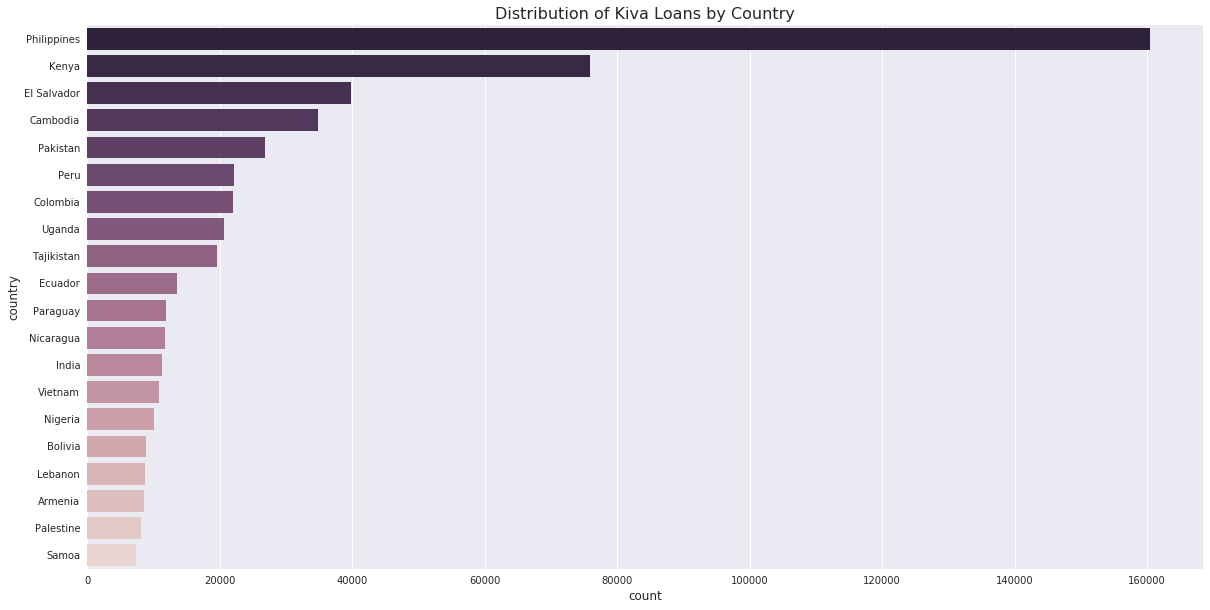

In [3]:
# Plot loans per country
sns.countplot(y="country", data=kiva_loans_df, 
              order=kiva_loans_df.country.value_counts().iloc[:20].index).set_title("Distribution of Kiva Loans by Country")

In [4]:
countries_funded_amount = kiva_loans_df.groupby('country').sum()['funded_amount'].sort_values(ascending = False)
data = [dict(
        type='choropleth',
        locations= countries_funded_amount.index,
        locationmode='country names',
        z=countries_funded_amount.values,
        text=countries_funded_amount.index,
        colorscale = [[0,'rgb(216, 191, 216)'],[1,'rgb(75, 0, 130)']],
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Total Loan Amount by Country'),
)]
layout = dict(title = 'Total Loan Amount by Country', 
        geo = dict(
            showframe = False, 
            showcoastlines = True, 
            projection = dict(type = 'Mercator')
        ))
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='loans-total-map')

Text(0.5,1,'Distribution of Loans by Sector')

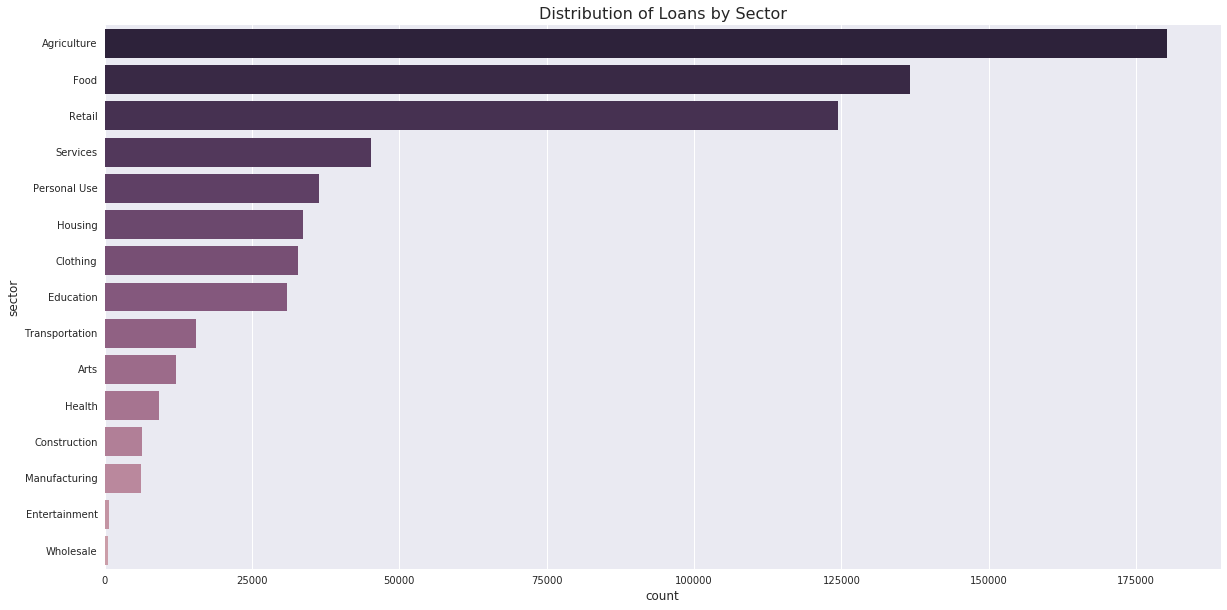

In [5]:
# Plot loans per sector
sns.countplot(y="sector", data=kiva_loans_df, 
              order=kiva_loans_df.sector.value_counts().iloc[:20].index).set_title("Distribution of Loans by Sector")

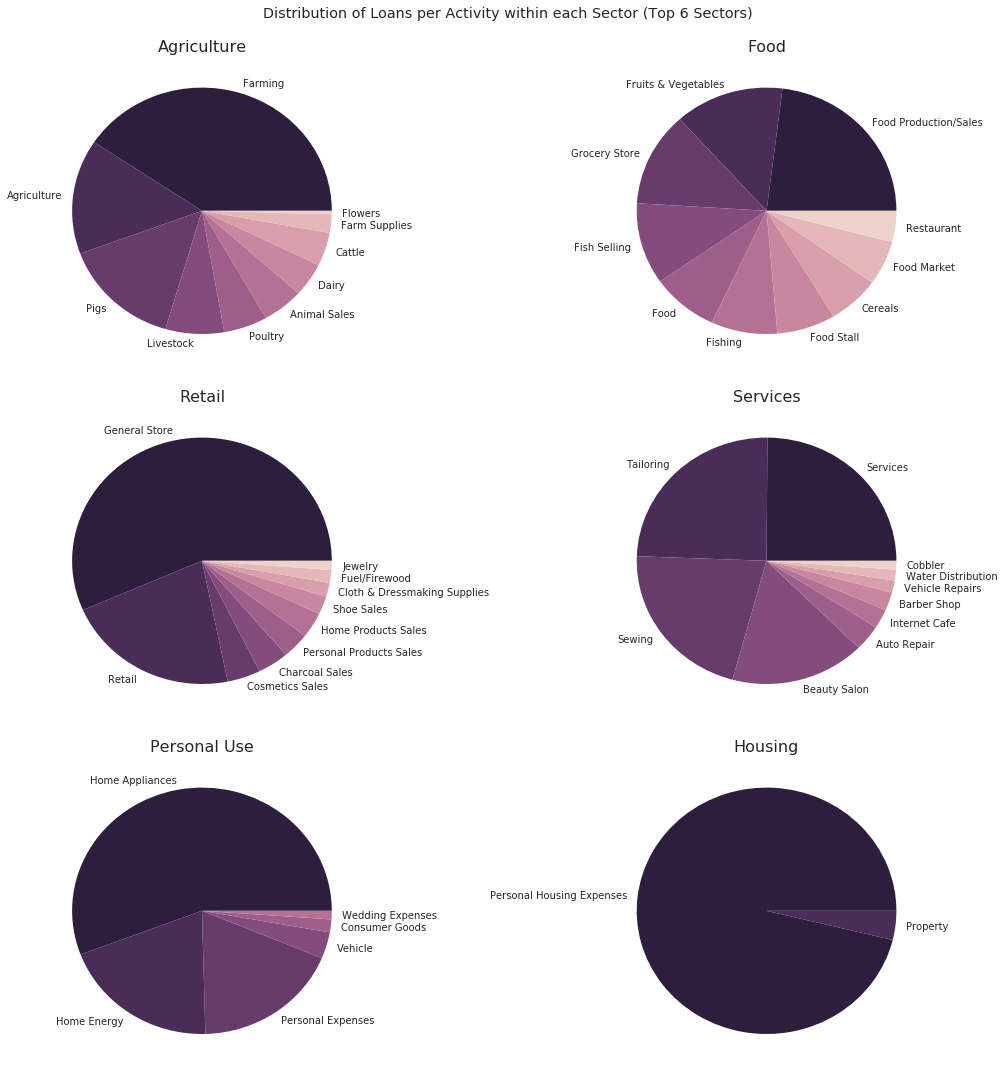

In [6]:
# Plot loans per activity per sector (top sectors only)

#with sns.color_palette("BrBG",10):
with sns.cubehelix_palette(10, reverse=True):
    plt.figure(figsize=(13,15))

    plt.subplot(321).set_title("Agriculture")
    kiva_loans_df.loc[kiva_loans_df['sector'] == "Agriculture"].activity.value_counts().iloc[:10].T.plot.pie(labeldistance=1.08)
    plt.ylabel('')

    plt.subplot(322).set_title("Food")
    kiva_loans_df.loc[kiva_loans_df['sector'] == "Food"].activity.value_counts().iloc[:10].T.plot.pie(labeldistance=1.08)
    plt.ylabel('')

    plt.subplot(323).set_title("Retail")
    kiva_loans_df.loc[kiva_loans_df['sector'] == "Retail"].activity.value_counts().iloc[:10].T.plot.pie(labeldistance=1.08)
    plt.ylabel('')
    
    plt.subplot(324).set_title("Services")
    kiva_loans_df.loc[kiva_loans_df['sector'] == "Services"].activity.value_counts().iloc[:10].T.plot.pie(labeldistance=1.08)
    plt.ylabel('')
    
    plt.subplot(325).set_title("Personal Use")
    kiva_loans_df.loc[kiva_loans_df['sector'] == "Personal Use"].activity.value_counts().iloc[:6].T.plot.pie(labeldistance=1.08)
    plt.ylabel('')

    plt.subplot(326).set_title("Housing")
    kiva_loans_df.loc[kiva_loans_df['sector'] == "Housing"].activity.value_counts().T.plot.pie(labeldistance=1.08)
    plt.ylabel('')

    plt.suptitle('Distribution of Loans per Activity within each Sector (Top 6 Sectors)')
    plt.tight_layout(pad=0.0, w_pad=20.0, h_pad=2.0, rect=[0, 0, 0.95, 0.95])
    plt.show()

In [7]:
# On closer examination of the data, we notice there is one loan of 100K which is an outlier. 
# The outliers are truncated to enable better visualisation of the data.
percentile_99 = np.percentile(kiva_loans_df.loan_amount.values, 99)
kiva_loans_df['loan_amount_trunc'] = kiva_loans_df['loan_amount'].copy()
kiva_loans_df.loc[kiva_loans_df['loan_amount_trunc'] > percentile_99, 'loan_amount_trunc'] = percentile_99

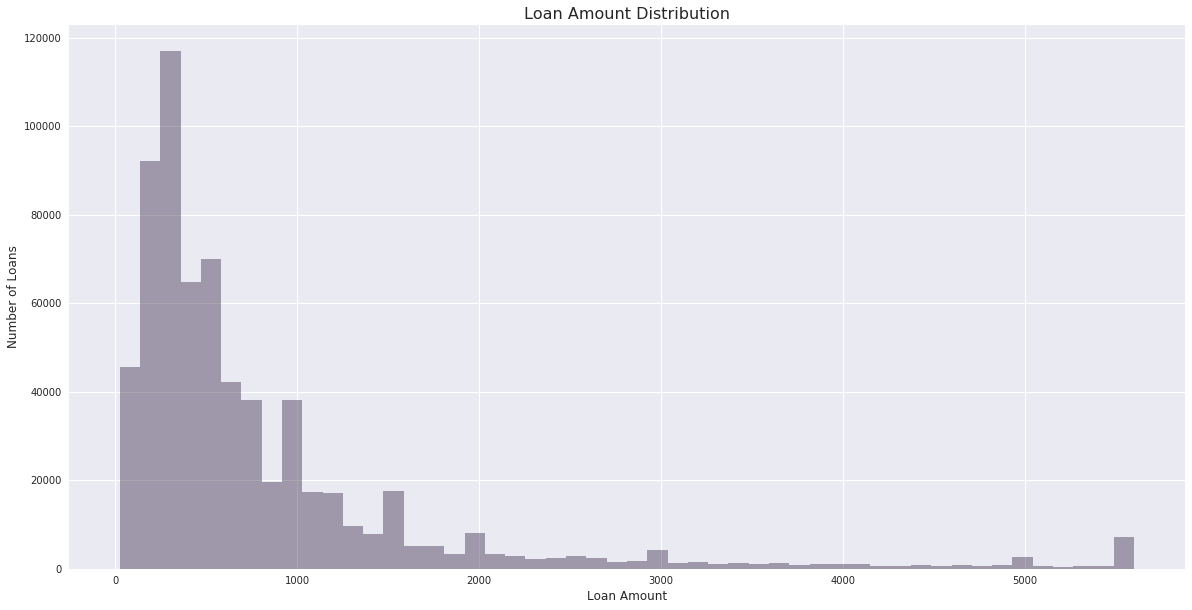

In [8]:
# Plot loan amount histogram
sns.distplot(kiva_loans_df.loan_amount_trunc.values, kde=False)
plt.title("Loan Amount Distribution")
plt.xlabel('Loan Amount')
plt.ylabel('Number of Loans')
plt.show()

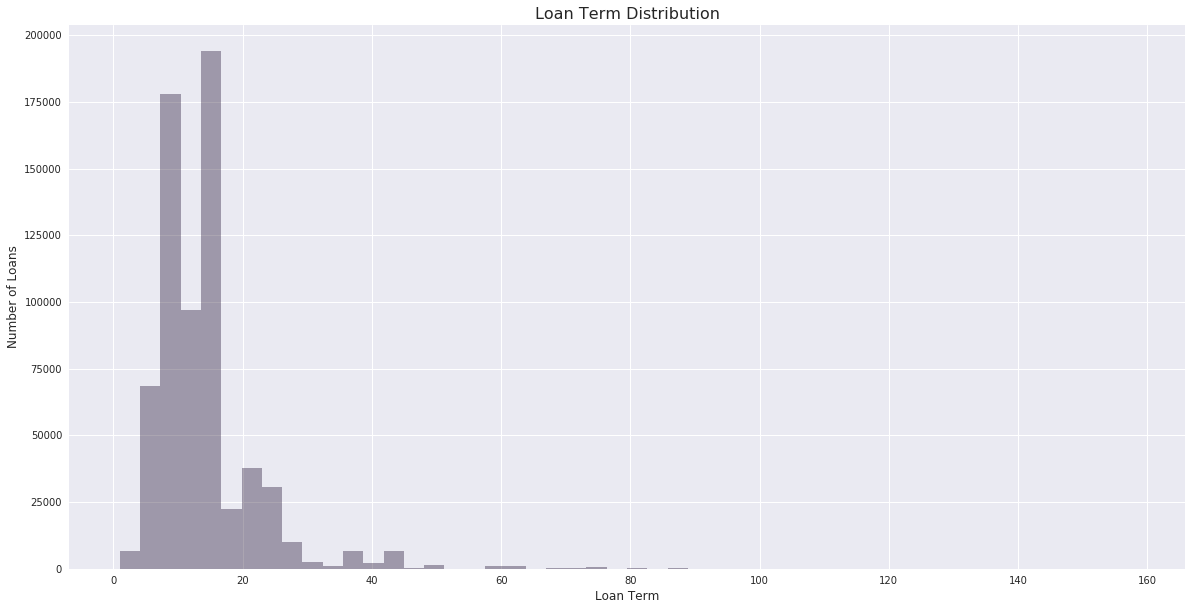

In [9]:
# Plot repayent term histogram
sns.distplot(kiva_loans_df.term_in_months.values, kde=False)
plt.title("Loan Term Distribution")
plt.xlabel('Loan Term')
plt.ylabel('Number of Loans')
plt.show()

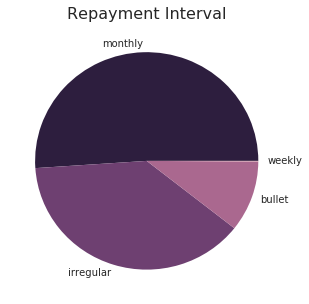

In [10]:
# Plot repayment interval of loans
with sns.cubehelix_palette(5, reverse=True):
    plt.figure(figsize=(5,5))
    plt.title("Repayment Interval")
    kiva_loans_df.repayment_interval.value_counts().T.plot.pie(labeldistance=1.08)
    plt.ylabel('')

In [11]:
# On closer examination of the data, we notice there are also outliers on high end for number of lenders
# The outliers are truncated to enable better visualisation of the data.
percentile_99 = np.percentile(kiva_loans_df.lender_count.values, 99)
kiva_loans_df['lender_count_trunc'] = kiva_loans_df['lender_count'].copy()
kiva_loans_df.loc[kiva_loans_df['lender_count_trunc'] > percentile_99, 'lender_count_trunc'] = percentile_99

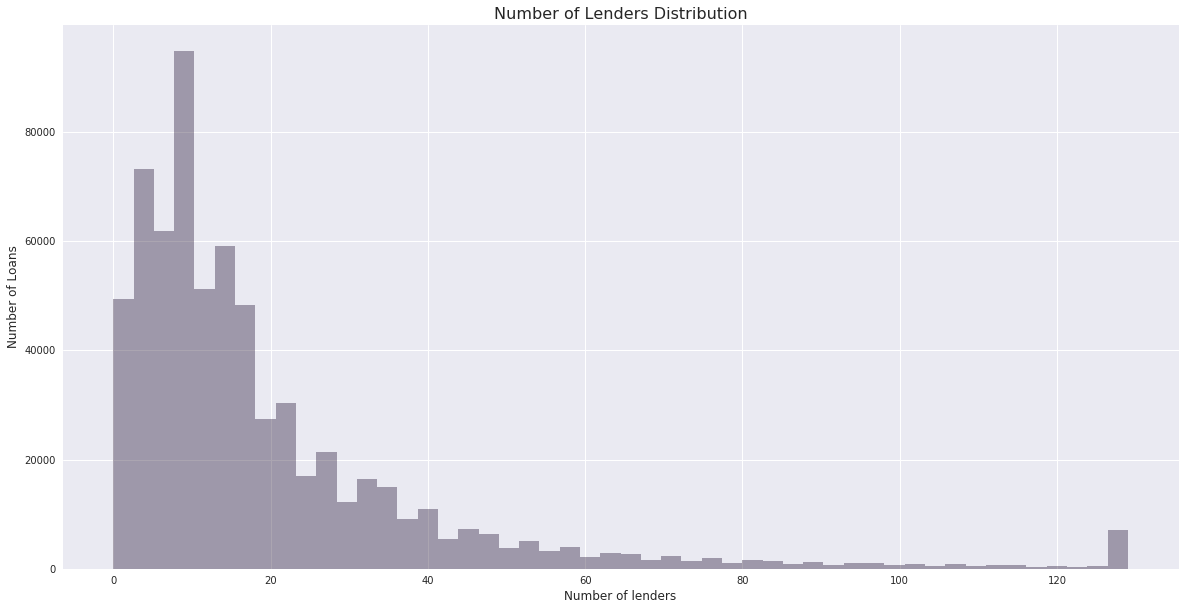

In [12]:
# Plot Lender count
sns.distplot(kiva_loans_df.lender_count_trunc.values, kde=False)
plt.title("Number of Lenders Distribution")
plt.xlabel('Number of lenders')
plt.ylabel('Number of Loans')
plt.show()

## Multi-dimensional Poverty Idex

In [28]:
kiva_mpi_locations_df.head()
kiva_mpi_locations_df.shape

(2772, 9)

In [33]:
c = kiva_mpi_locations_df[pd.notnull(kiva_mpi_locations_df['MPI'])]
kiva_mpi_locations_filtered_df.shape

(984, 9)

In [43]:
kiva_mpi_locations_filtered_df.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



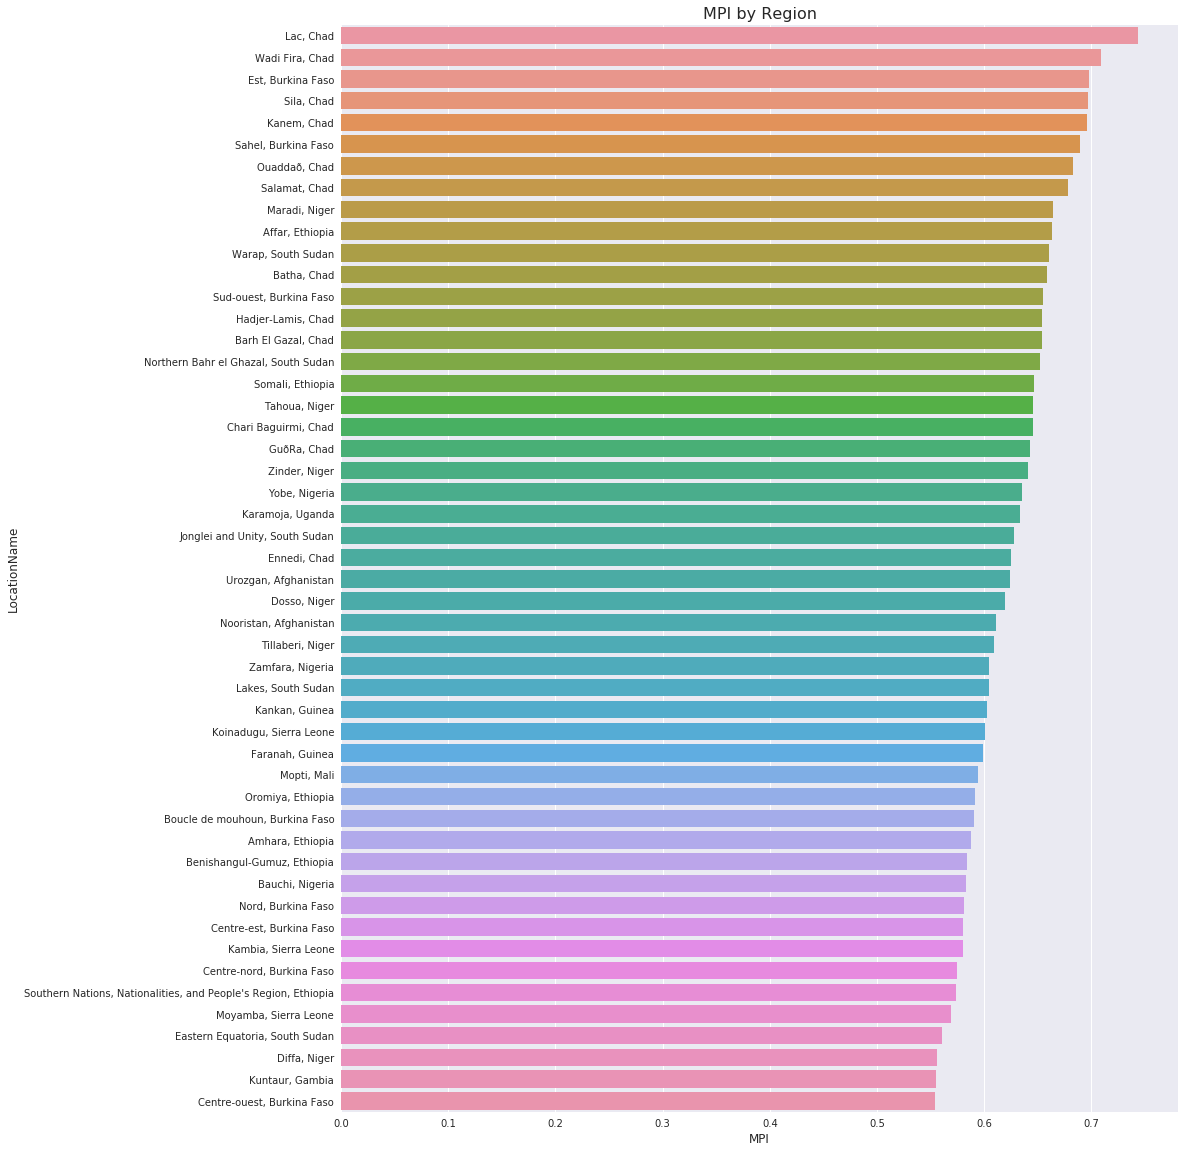

In [61]:
# Plot MPI by Region
plt.figure(figsize=(15,20))

kiva_mpi_locations_filtered_df.sort_values(by="MPI", ascending=False, inplace=True)
mpi_top_20_region = kiva_mpi_locations_filtered_df.head(50)
sns.barplot(mpi_top_20_region.MPI, mpi_top_20_region.LocationName)

plt.title("MPI by Region")
plt.show()

In [38]:
data = [dict(
        type='choropleth',
        locations= kiva_mpi_locations_filtered_df.country,
        locationmode='country names',
        z=kiva_mpi_locations_filtered_df.MPI,
        text=kiva_mpi_locations_filtered_df.index,
        colorscale = [[0,'rgb(216, 191, 216)'],[1,'rgb(75, 0, 130)']],
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='MPI by Country'),
)]

layout = dict(title = 'MPI by Country', 
        geo = dict(
            showframe = False, 
            showcoastlines = True, 
            projection = dict(type = 'Mercator')
        ))
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='mpi-region-map')


In [42]:
data = [ dict(
        type = 'scattergeo',
        lon = kiva_mpi_locations_df['lon'],
        lat = kiva_mpi_locations_df['lat'],
        text = kiva_mpi_locations_df['LocationName'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = [[0,'rgb(216, 191, 216)'],[1,'rgb(75, 0, 130)']],
            cmin = 0,
            color = kiva_mpi_locations_df['MPI'],
            cmax = kiva_mpi_locations_df['MPI'].max(),
            colorbar=dict(
                title="Multi-dimenstional Poverty Index"
            )
        ))]

layout = dict(title = 'MPI by Country', 
        geo = dict(
            showframe = False, 
            showcoastlines = True, 
            projection = dict(type = 'Mercator')
        ))
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='mpi-region-map')